In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error
from mlxtend.regressor import StackingRegressor
from category_encoders import TargetEncoder
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold
import lightgbm as ltb
import re
import random

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.20.3


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
!ls '../input'

parsing-all-moscow-auto-ru-09-09-2020  sf-dst-car-price-prediction


In [8]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [10]:
train.dropna(subset=['price'], inplace=True) # drop columns without  pricew

In [11]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 88968 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              88967 non-null  object 
 1   brand                 88968 non-null  object 
 2   color                 88968 non-null  object 
 3   fuelType              88968 non-null  object 
 4   modelDate             88967 non-null  float64
 5   name                  88967 non-null  object 
 6   numberOfDoors         88967 non-null  float64
 7   productionDate        88968 non-null  int64  
 8   vehicleConfiguration  88967 non-null  object 
 9   vehicleTransmission   88967 non-null  object 
 10  engineDisplacement    88967 non-null  object 
 11  enginePower           88967 non-null  float64
 12  description           85734 non-null  object 
 13  mileage               88968 non-null  int64  
 14  Комплектация          88968 non-null  object 
 15  Привод             

In [12]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Data Preprocessing

In [14]:
# ... 

In [15]:
# для baseline просто возьму пару схожих признаков без полной обработки

df_train = train
df_test = test

## Label Encoding

In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [17]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df)

# What to do.

I'll drop 'model' and create new model column from 'car_url', think that way will be easier

delete columns which are not in train DataSet

'body_type' glue duplicates, and delete almost empty row

'colors' also glue

engineDisplacement column is not informative, same info even more is in 'name' column, but need to take it out,
same stuff with 'vehicleConfiguration', I need only gear type from it, because I don't want to recode 'vehicleTransmission'

'Владельцы' glue it

'ПТС' have NaNs, but not so much, will fill it randomly, and glue it

'mileage' are cars without mileage, will fill them with mean value +- 50 000

'Руль' glue it


## Drop

'name','engineDisplacement', 'enginePower', 'vehicleConfiguration', 'description', 'hidden'
'vehicleTransmission', 'Состояние', 'Таможня', 'start_date', 'Комплектация', 'productionDate', 'Владение'

In [18]:
df.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'sample', 'Комплектация',
       'price', 'start_date', 'hidden', 'model'],
      dtype='object')

In [19]:
def pre_proc():
    def model():
        df['temp']= df['car_url'].str.replace(r"https://auto.ru/cars/used/sale/","") # delete trash in front
        df['temp']= df['temp'].str.split('/').str[1] # separate
        df['model']= df['model'].str.lower() # small letters
        df['model']= np.where(df['model'].isnull(), df['temp'], df['model']) # fill NaNs
        df.drop('temp', axis=1) # delete temporary col
    
    def columns():
        global df# if columns in df not in train, drop it
        for col in df.columns:
            if col not in train.columns:
                df = df.drop(col, axis=1)
       
    def body_type():
        df['bodyType'] = df['bodyType'].str.split().str[0] 
        df['bodyType'] = df['bodyType'].str.split('-').str[0]
        df['bodyType'] = df['bodyType'].str.lower()
        index = df.loc[pd.isna(df["bodyType"]), :].index # find row by index
        df.drop(index = index, axis = 0, inplace=True) # delete almost empty row
            
    def colors():
        # i'll make a library
        color_lib = {"чёрный": "000000","белый": "FFFFFF", "серебристый": "C0C0C0", "серый": "808080", "синий": "0000FF", "красный": "FF0000", "коричневый": "964B00",
                     "зелёный": "008000", "бежевый": "F5F5DC", "голубой": "00BFFF", "золотистый": "FFD700", "пурпурный": "FF00FF", "фиолетовый": "8B00FF", "жёлтый": "FFFF00", 
                      "оранжевый": "FFA500", "розовый": "FFC0CB"}

        for value in df['color']: # cycle for recode colours
            for color, code in color_lib.items():
                if value == color:
                    df['color'] = df['color'].replace(value,code)
      
    def capacity(): # create column with engine capacity
        pattern = re.compile('\d\.\d') # search pattern
        df['capacity'] = df['name'].apply(lambda x: pattern.findall(str(x))) # take out from rows only engine capacity
        df['capacity'] = df['capacity'].astype(str).str.replace(r"\[","").str.replace(r"\]","") # delete ]
        df['capacity'] = df['capacity'].astype(str).str.replace(r"\'","").str.replace(r"\'","") # delete '
        df['capacity'] = df['capacity'].str.split(',').str[0] # drop duplicates
        df.loc[df['capacity'] == '','capacity'] = 0 # 0 is for electric motors
        df['capacity'] = df['capacity'].astype(float) # convert to float
          
    def hp():  # create column with horse powers
        df['hp'] = df['name'].str.split('(').str[1] # take out from rows only horse powers
        df['hp'] = df['hp'].str.split(' ').str[0] # cleaning
        df['hp'] = df['hp'].str.split('.').str[0] # cleaning
        df['hp'] = df['hp'].astype(int)

    def gear_type(): 
        df['gear_type'] = df['vehicleConfiguration'].str.split(' ').str[1] # take out from rows only gear type
        df['gear_type'] = df['gear_type'].str.split(' ').str[0] # cleaning
 
    def owners():
        df['Владельцы'] = df['Владельцы'].replace('3 или более',3)
        df['Владельцы'] = df['Владельцы'].replace('1\xa0владелец',1)  
        df['Владельцы'] = df['Владельцы'].replace('2\xa0владельца',2)  
        df['Владельцы'] = df['Владельцы'].apply(lambda x: x if not np.isnan(x) else np.random.choice([1, 2, 3]))
        
    def own_prove():
        df['ПТС'] = df['ПТС'].replace('Оригинал','ORIGINAL')
        df['ПТС'] = df['ПТС'].replace('Дубликат','DUPLICATE')
        df['ПТС'] = df['ПТС'].apply(lambda x: x if not pd.isnull(x) else np.random.choice(['ORIGINAL','DUPLICATE']))
         
    def mileage():
        df['mileage'] = df['mileage'].apply(lambda x: np.random.randint(100000,200000) if x==0 else x) # if 0 fill random
         
    def ster_wheel():
        df['Руль'] = df['Руль'].replace('Левый','LEFT')
        df['Руль'] = df['Руль'].replace('Правый','RIGHT')
        
    model()
    columns()
    body_type()
    colors()
    capacity()
    hp()
    gear_type()
    owners()
    own_prove()
    mileage()
    ster_wheel()
    
    df.drop(['name','engineDisplacement', 'enginePower', 'vehicleConfiguration', 'description', 'hidden',
         'vehicleTransmission', 'Состояние', 'Таможня', 'start_date', 'Комплектация', 'productionDate', 'Владение'], axis=1, inplace=True)

pre_proc()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: The default value of regex will change from True to False in a future version.


# EDA

In [20]:
# separate for type
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'model', 'gear_type']
num_cols = ['mileage', 'modelDate', 'capacity', 'hp', 'numberOfDoors']
bool_cals = ['sample']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


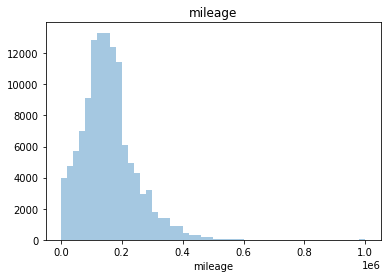

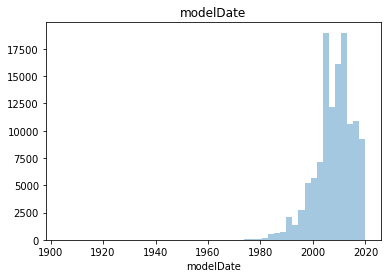

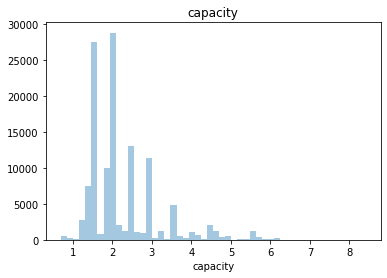

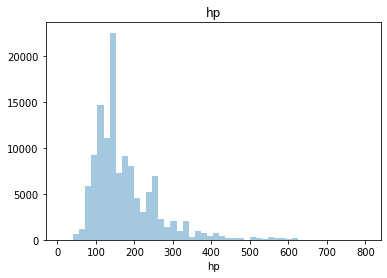

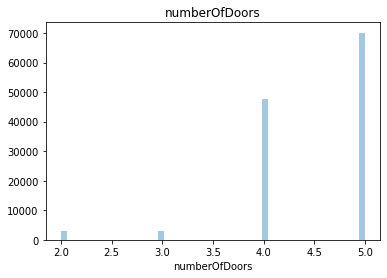

In [21]:
# num_cols
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Disproportion in values. Try log it.

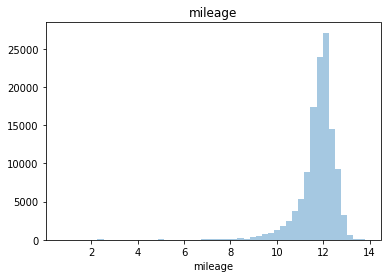

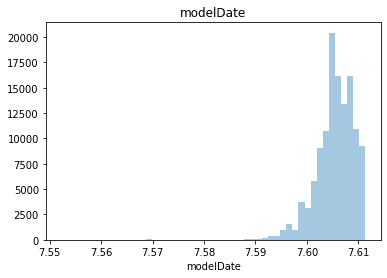

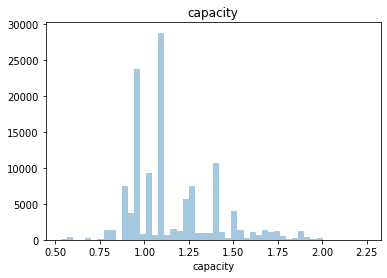

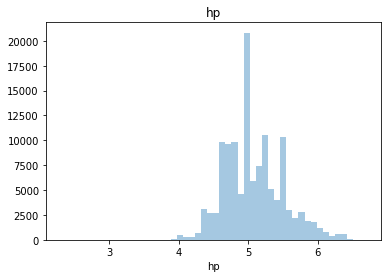

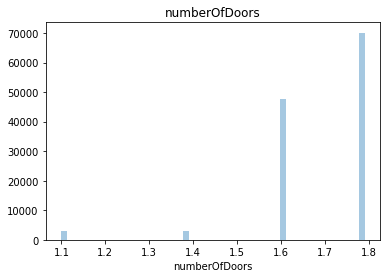

In [22]:
for i in num_cols:
    df[i]= df[i].apply(lambda x: np.log(x+1))
    
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()   

In [23]:
df[num_cols].describe()

,mileage,modelDate,capacity,hp,numberOfDoors
count,123653.000000,123653.000000,123653.000000,123653.000000,123653.000000
mean,11.747737,7.605451,1.149037,5.081176,1.694816
std,0.898283,0.003716,0.245672,0.422135,0.138809
min,0.693147,7.552237,0.000000,2.302585,0.000000
25%,11.520854,7.603898,0.955511,4.770685,1.609438
50%,11.911708,7.605890,1.098612,5.017280,1.791759
75%,12.206078,7.607878,1.252763,5.351858,1.791759
max,13.815512,7.611348,2.240710,6.685861,1.791759


<AxesSubplot:>

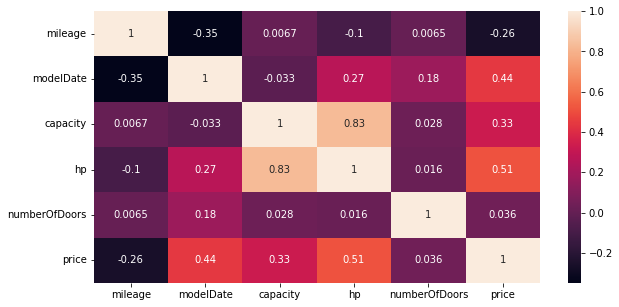

In [24]:
## compare price by mileage
plt.figure(figsize=(10,5))
sns.heatmap(df[num_cols+['price']].dropna().corr(), annot=True)

In [25]:
df[num_cols+['price']].dropna().corr()

,mileage,modelDate,capacity,hp,numberOfDoors,price
mileage,1.000000,-0.348835,0.006666,-0.099720,0.006545,-0.260620
modelDate,-0.348835,1.000000,-0.032607,0.267108,0.177180,0.439334
capacity,0.006666,-0.032607,1.000000,0.831241,0.028295,0.328500
hp,-0.099720,0.267108,0.831241,1.000000,0.015976,0.514803
numberOfDoors,0.006545,0.177180,0.028295,0.015976,1.000000,0.036020
price,-0.260620,0.439334,0.328500,0.514803,0.036020,1.000000


Most corrilated are modelDate, capacity and hp

<AxesSubplot:>

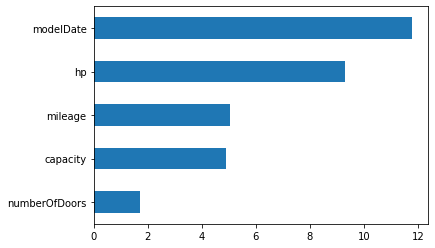

In [26]:
imp_num = pd.Series(f_classif(df[num_cols], df['price'].fillna(0))[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Interesting, most important is modelDate

<AxesSubplot:>

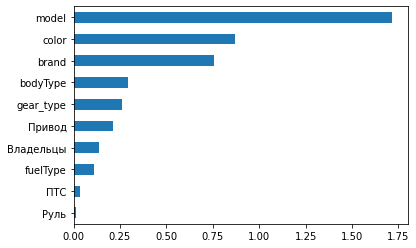

In [27]:
# num_cols
# will use LabelEncoder to transform 
label_encoder = LabelEncoder()
viz = pd.DataFrame()
for column in cat_cols:
    viz[column] = label_encoder.fit_transform(df[column])
       
    
# check which col is more important
imp_cat = pd.Series(mutual_info_classif(viz, df['price'].fillna(0),
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')    

model is more important, as I thought, probably because people are looking for exact model, only then looking on other parametrs. Funny then color is second one

# Encoding

In [28]:
y = df['price'].dropna().values
Xtrain = df.query('sample == 1').drop(['sample','price'], axis=1)
Xtest = df.query('sample == 0').drop(['sample','price'], axis=1)

In [29]:
# OneHotEncoder
ohe = OneHotEncoder(sparse = False)
cat = ohe.fit_transform(df[cat_cols])

temp = np.hstack([cat, df[num_cols],df[bool_cals]])

train_data= temp[temp[::,-1] == 1]
train_data= np.delete(train_data, -1, axis=1)

test_data= temp[temp[::,-1] == 0]
test_data= np.delete(test_data, -1, axis=1)

In [30]:
np.save('data.npy', train_data)
np.save('target.npy', y)


# Train Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [32]:
#RobustScaler
transformer = RobustScaler().fit(X_train)

X_test = transformer.transform(X_test)
X_train = transformer.transform(X_train)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [33]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(Xtrain, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

tmp_train = X_train_n.copy()
tmp_train['price'] = y_train_n

In [34]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test_n['capacity'].map(tmp_train.groupby('capacity')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test_n, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: nan%


# # Model 2 : CatBoost
  


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [35]:
cbr = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
cbr.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

cbr.save_model('catboost_single_model_baseline.model')

In [36]:
# оцениваем точность
predict = cbr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 16.44%


Catboost

MAPE: 16.44%

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [37]:
np.log(y_train)

array([13.57978822, 11.98292909, 13.52782849, ..., 13.12236338,
       12.64109656, 14.40329722])

In [38]:
cbr = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
cbr.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

cbr.save_model('catboost_single_model_2_baseline.model')

In [39]:
predict_test = np.exp(cbr.predict(X_test))
predict_submission = np.exp(cbr.predict(test_data))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.69%


Catboost log(y)

MAPE: 13.69%

# Lazy_predict made in colab

Model                          Adjusted R-Squared  R-Squared       RMSE                                    
GaussianProcessRegressor                    19.73     -93.66 6234497.80   
LinearSVR                                    1.40      -1.02  911528.98   
MLPRegressor                                 1.40      -1.02  911468.75   
KernelRidge                                  1.24      -0.24  712773.89   
SVR                                          1.22      -0.10  670968.41   
NuSVR                                        1.21      -0.04  654640.24   
DummyRegressor                               1.20      -0.00  641043.87   
LassoLarsIC                                  1.20      -0.00  641043.87   
ElasticNetCV                                 1.20       0.01  636714.64   
PassiveAggressiveRegressor                   1.07       0.66  374689.11   
GammaRegressor                               1.05       0.76  311794.28   
TweedieRegressor                             1.04       0.80  283862.19   
GeneralizedLinearRegressor                   1.04       0.80  283862.19   
ElasticNet                                   1.03       0.86  243359.14   
KNeighborsRegressor                          1.03       0.86  239804.51   
SGDRegressor                                 1.03       0.87  234312.54   
Lars                                         1.02       0.90  200907.04   
HuberRegressor                               1.02       0.90  200082.78   
LarsCV                                       1.02       0.91  195863.38   
OrthogonalMatchingPursuitCV                  1.02       0.91  192535.89   
LinearRegression                             1.02       0.91  192087.97   
TransformedTargetRegressor                   1.02       0.91  192087.97   
RidgeCV                                      1.02       0.91  191766.88   
BayesianRidge                                1.02       0.91  191347.46   
OrthogonalMatchingPursuit                    1.02       0.91  191344.95   
Lasso                                        1.02       0.91  191343.20   
Ridge                                        1.02       0.91  191286.79   
LassoLars                                    1.02       0.91  190874.44   
LassoLarsCV                                  1.02       0.91  190606.23   
LassoCV                                      1.02       0.91  190345.51   
AdaBoostRegressor                            1.01       0.93  174836.49   
PoissonRegressor                             1.01       0.96  133007.52   
DecisionTreeRegressor                        1.01       0.96  125659.45   
GradientBoostingRegressor                    1.01       0.97  113693.52   
ExtraTreeRegressor                           1.01       0.97  111905.47   
LGBMRegressor                                1.01       0.97  108533.70   
BaggingRegressor                             1.01       0.97  105444.08   
HistGradientBoostingRegressor                1.01       0.97  105201.86   
XGBRegressor                                 1.01       0.97  102597.51   
RandomForestRegressor                        1.00       0.98   98598.35   
ExtraTreesRegressor                          1.00       0.98   92550.12   

                               Time Taken  
Model                                      
GaussianProcessRegressor             0.96  
LinearSVR                            0.14  
MLPRegressor                         7.81  
KernelRidge                          0.21  
SVR                                  1.69  
NuSVR                                1.16  
DummyRegressor                       0.08  
LassoLarsIC                          0.51  
ElasticNetCV                         2.00  
PassiveAggressiveRegressor           4.88  
GammaRegressor                       0.11  
TweedieRegressor                     0.15  
GeneralizedLinearRegressor           0.14  
ElasticNet                           0.11  
KNeighborsRegressor                  0.67  
SGDRegressor                         0.13  
Lars                                 0.45  
HuberRegressor                       0.62  
LarsCV                               1.67  
OrthogonalMatchingPursuitCV          0.32  
LinearRegression                     0.51  
TransformedTargetRegressor           0.49  
RidgeCV                              0.36  
BayesianRidge                        2.72  
OrthogonalMatchingPursuit            0.12  
Lasso                                0.49  
Ridge                                0.16  
LassoLars                            0.51  
LassoLarsCV                          1.21  
LassoCV                              2.50  
AdaBoostRegressor                    0.62  
PoissonRegressor                     0.24  
DecisionTreeRegressor                0.14  
GradientBoostingRegressor            0.76  
ExtraTreeRegressor                   0.13  
LGBMRegressor                        0.19  
BaggingRegressor                     0.30  
HistGradientBoostingRegressor       12.24  
XGBRegressor                         3.43  
RandomForestRegressor                1.60  
ExtraTreesRegressor                  2.04

## Depending on result and time taken I'll take for stacking:
### ExtraTreesRegressor 
### RandomForestRegressor
### XGBRegressor
### LGBMRegressor

let's take linear rigression for baggingregressor and log(y)

In [ ]:
# will use like meta model
lr = LinearRegression(n_jobs=-1).fit(X_train, y_train)

pred = lr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred))*100:0.2f}%")

In [ ]:
# regressors
br = BaggingRegressor(base_estimator=lr, random_state=RANDOM_SEED, n_jobs=-1).fit(X_train, y_train)

pred_br = br.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_br))*100:0.2f}%")

BaggingRegressor with default params

MAPE: 11226332389.41%

In [ ]:
br = BaggingRegressor(base_estimator=lr, random_state=RANDOM_SEED, n_jobs=-1,
                      n_estimators=50).fit(X_train, y_train)

pred_br = br.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_br))*100:0.2f}%")

In [ ]:
br = BaggingRegressor(base_estimator=lr, random_state=RANDOM_SEED, n_jobs=-1,
                      n_estimators=30, 
                      max_samples=0.2 ).fit(X_train, np.log(y_train))

pred_br = br.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_br))*100:0.2f}%")

In [ ]:
br = BaggingRegressor(base_estimator=lr, random_state=RANDOM_SEED, n_jobs=-1,
                      n_estimators=20, 
                      max_samples= 0.8,
                      max_features = 0.2
                     ).fit(X_train, np.log(y_train))

pred_br = br.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_br))*100:0.2f}%")

In [ ]:
br = BaggingRegressor(base_estimator=lr, random_state=RANDOM_SEED, n_jobs=-1,
                      n_estimators=15, 
                      max_samples= 0.5,
                      max_features = 0.8
                     ).fit(X_train, np.log(y_train))

pred_br = br.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_br))*100:0.2f}%")

## LGBMRegressor

In [ ]:
lgbm = ltb.LGBMRegressor(random_state=RANDOM_SEED, n_jobs=-1).fit(X_train, np.log(y_train))

pred_lgbm = np.exp(lgbm.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_lgbm))*100:0.2f}%")

LGBM default

MAPE: 16.11%

In [ ]:
lgbm = ltb.LGBMRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                        learning_rate=0.09).fit(X_train, np.log(y_train))

pred_lgbm = np.exp(lgbm.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_lgbm))*100:0.2f}%")

LGBM learning_rate=0.09

MAPE: 16.42%

In [ ]:
lgbm = ltb.LGBMRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                        learning_rate=0.09,
                        max_depth=-5).fit(X_train, np.log(y_train))

pred_lgbm = np.exp(lgbm.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_lgbm))*100:0.2f}%")

LGBM learning_rate=0.09m max_depth=-5

MAPE: 16.42%

In [ ]:
lgbm = ltb.LGBMRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                        learning_rate=0.5,
                        max_depth= 50,
                        max_bin=100,
                        n_estimators=500).fit(X_train, np.log(y_train))

pred_lgbm = np.exp(lgbm.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_lgbm))*100:0.2f}%")

LGBM learning_rate=0.5, max_depth=-1

MAPE: 14.28%

## RandomForestRegressor and ExtraTreesRegressor

In [ ]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1).fit(X_train, y_train)

pred_rfr = rfr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_rfr))*100:0.2f}%")

RandomForestRegressor with default params

MAPE: 14.56%

In [ ]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED,  n_jobs=-1).fit(X_train, y_train)

pred_etr = etr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_etr))*100:0.2f}%")

ExtraTreesRegressor with default params

MAPE: 15.14%

In [ ]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1).fit(X_train, np.log(y_train))

pred_rfr = np.exp(rfr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_rfr))*100:0.2f}%")

## all experiments gona be with log(y)

RandomForestRegressor with default params

MAPE: 13.86%

In [ ]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED,  n_jobs=-1,max_depth=10).fit(X_train, np.log(y_train))

pred_etr = np.exp(etr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_etr))*100:0.2f}%")

ExtraTreesRegressor with depth = 10

MAPE: 14.68%

In [ ]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,max_depth=10).fit(X_train, np.log(y_train))

pred_rfr = np.exp(rfr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_rfr))*100:0.2f}%")

RandomForestRegressor with depth = 10

MAPE: 17.88%

In [ ]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,max_depth=100, n_estimators=200).fit(X_train, np.log(y_train))

pred_rfr = np.exp(rfr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_rfr))*100:0.2f}%")

RandomForestRegressor with depth=100, estimators=200

MAPE: 13.83%

In [ ]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED,  n_jobs=-1,max_depth=100,
                          min_samples_split= 5, n_estimators=200).fit(X_train, np.log(y_train))

pred_etr = np.exp(etr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_etr))*100:0.2f}%")

ExtraTreesRegressor with max_depth=100, min_samples_split= 5, n_estimators=200

MAPE: 13.95%

In [ ]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,max_depth=10,
                            n_estimators=200, min_samples_split= 10).fit(X_train, np.log(y_train))

pred_rfr = np.exp(rfr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_rfr))*100:0.2f}%")

RandomForestRegressor max_depth=10, n_estimators=200, min_samples_split= 10

MAPE: 17.87%

In [ ]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1,max_depth=100,
                            n_estimators=200,  min_samples_split= 5).fit(X_train, np.log(y_train))

pred_etr = np.exp(etr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_etr))*100:0.2f}%")

ExtraTreesRegressor with max_depth=100, n_estimators=200,  min_samples_split= 5

MAPE: 14.05%

In [41]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,max_depth=100,
                            n_estimators=200, min_samples_split= 15).fit(X_train, np.log(y_train))

pred_rfr = np.exp(rfr.predict(X_test))
predict_submission = np.exp(rfr.predict(test_data))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_rfr))*100:0.2f}%")

Точность модели по метрике MAPE: 13.62%


RandomForestRegressor with max_depth=100, n_estimators=200, min_samples_split= 15

MAPE: 13.62%

# xgbregressor

In [ ]:
xgb = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1).fit(X_train, np.log(y_train))

pred_xgb = np.exp(xgb.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_xgb))*100:0.2f}%")

In [ ]:
xgb = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, 
                   n_estimators = 250).fit(X_train, np.log(y_train))

pred_xgb = np.exp(xgb.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_xgb))*100:0.2f}%")

XGBRegressor with n_estimators = 250

MAPE: 14.50%

In [ ]:
xgb = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, 
                   n_estimators = 200).fit(X_train, np.log(y_train))

pred_xgb = np.exp(xgb.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_xgb))*100:0.2f}%")

XGBRegressor with n_estimators = 200

MAPE: 14.72%

In [ ]:
xgb = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, 
                   n_estimators = 200, max_depth= 5).fit(X_train, np.log(y_train))

pred_xgb = np.exp(xgb.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_xgb))*100:0.2f}%")

XGBRegressor n_estimators = 200, max_depth= 5

MAPE: 15.08%

In [ ]:
xgb = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, 
                   n_estimators = 250, max_depth= 7).fit(X_train, np.log(y_train))

pred_xgb = np.exp(xgb.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_xgb))*100:0.2f}%")

XGBRegressor with n_estimators = 250, max_depth= 7

MAPE: 14.36%

# Stacking with K-fold

In [ ]:
# Stacking
rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                            max_depth=100, n_estimators=200)
etr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                          max_depth=100, n_estimators=200,  min_samples_split= 5)
lgbm = ltb.LGBMRegressor(random_state=RANDOM_SEED, n_jobs=-1,
                        learning_rate=0.5, max_depth= 50,
                        max_bin=100, n_estimators=500)

stregr = StackingRegressor(regressors=[rfr, etr, lgbm], 
                           meta_regressor=lr)

In [ ]:
# K-fold
kf = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True) 
X_fold = train_data

for train_index, test_index in kf.split(train_data):
    X_train_k, X_test_k = X_fold[train_index], X_fold[test_index]
    y_train_k, y_test_k = y[train_index], y[test_index]
    stregr.fit(X_train_k, np.log(y_train_k))
    
pred_stregr = np.exp(stregr.predict(X_test_k))
predict_submission = np.exp(stregr.predict(test_data))
print(f"Точность модели по метрике MAPE: {(mape(y_test_k, pred_stregr))*100:0.2f}%")

StackingRegressor with K-fold

MAPE: 14.44%

In [ ]:
# same on ttsplit
stregr.fit(X_train, np.log(y_train))
    
pred_stregr_tt = np.exp(stregr.predict(X_test))
predict_submission = np.exp(stregr.predict(test_data))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_stregr_tt))*100:0.2f}%")


StackingRegressor with tt split

MAPE: 14.45%

targ_enc = TargetEncoder(smoothing=8, min_samples_leaf=5)
targ_enc.fit(df[df['sample']==1][cat_cols], df[df['sample']==1]['price'])
df[cat_cols] = targ_enc.transform(df[cat_cols])

# Submission

In [42]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,1.941834e+07
1,1100549428,1.944187e+07
2,1100658222,1.944187e+07
3,1100937408,1.944187e+07
4,1101037972,1.944187e+07
5,1100912634,1.941834e+07
6,1101228730,1.856854e+07
7,1100165896,1.941834e+07
8,1100768262,1.856854e+07
9,1101218501,1.856854e+07


pip install --upgrade scipypip install --upgrade scipydf_train = train
df_testПодробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing